In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Read the data
df = pd.read_csv("../data/raw/data.csv")


In [3]:
df.head(1)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission
0,Internet,gp,30 GB,30 days,409,330,5


In [4]:
df[df['regularPrice'] == 0]

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20796 entries, 0 to 20795
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Bundle Type   20796 non-null  object
 1   operator      20796 non-null  object
 2   Product Name  20796 non-null  object
 3   validity      20796 non-null  object
 4   regularPrice  20796 non-null  object
 5   sellingPrice  20796 non-null  object
 6   commission    20796 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


In [6]:
for i in df.columns:
    print(i)

Bundle Type
operator
Product Name
validity
regularPrice
sellingPrice
commission


In [7]:
unique_value = 0
for i in df['Product Name'].value_counts().keys():
    unique_value += 1
print(unique_value)

289


In [8]:
print("Unique values count:")
for i in df.columns:
    print(f'{i} = {len(df[i].value_counts().values)}')

Unique values count:
Bundle Type = 3
operator = 4
Product Name = 289
validity = 6
regularPrice = 160
sellingPrice = 606
commission = 156


In [9]:
df.head()

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission
0,Internet,gp,30 GB,30 days,409,330,5
1,Intenet & Minute,gp,35 GB - 800 min,30 days,699,430,5
2,Intenet & Minute,robi,60 GB - 1300 min,30 days,799,567,7
3,Internet,gp,30 GB,30 days,409,321,6
4,Intenet & Minute,gp,35 GB - 800 min,30 days,699,440,20


In [11]:
# Drop the columns where 'registrationDate', 'division' are null and resetting index
# df = df.dropna(subset=['registrationDate', 'division']).reset_index(drop=True)


In [12]:
df.isnull().sum()

Bundle Type     0
operator        0
Product Name    0
validity        0
regularPrice    0
sellingPrice    0
commission      0
dtype: int64

In [13]:
df.head(2)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission
0,Internet,gp,30 GB,30 days,409,330,5
1,Intenet & Minute,gp,35 GB - 800 min,30 days,699,430,5


In [14]:
# df.orderStatus.value_counts()

In [15]:
df.columns

Index(['Bundle Type', 'operator', 'Product Name', 'validity', 'regularPrice',
       'sellingPrice', 'commission'],
      dtype='object')

In [16]:
df = df[['Bundle Type','operator', 'Product Name', 'validity', 'regularPrice',
       'sellingPrice', 'commission']]
df.head(2)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission
0,Internet,gp,30 GB,30 days,409,330,5
1,Intenet & Minute,gp,35 GB - 800 min,30 days,699,430,5


In [17]:
# def clean_data(df: pd.DataFrame) -> pd.DataFrame:
#     df['sellingPrice'] = df['sellingPrice'].replace({',': ''}, regex=True).astype(float)
#     df['regularPrice'] = df['regularPrice'].replace({',': ''}, regex=True).astype(float)
#     df['commission'] = df['commission'].astype(float)
#     df['Bundle Type'] = df['Bundle Type'].str.replace('Intenet & Minute', 'Internet & Minute')
    
#     # Drop rows where regularPrice and sellingPrice is 0 and reset index
#     df = df[df['regularPrice'] != 0].reset_index(drop=True)
#     df = df[df['sellingPrice'] != 0].reset_index(drop=True)

#     # Make sure sellingPrice and commission contains only positive values
#     df['sellingPrice'] = abs(df['sellingPrice'])
#     df['commission'] = abs(df['commission'])
#     return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the dataframe by handling missing values, converting datatypes, and filtering data
    """
    df = df.copy()
    
    # Convert price columns to numeric, removing commas
    for col in ['sellingPrice', 'regularPrice']:
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')
    
    df['commission'] = pd.to_numeric(df['commission'], errors='coerce')
    
    # Drop any rows with NaN values created during numeric conversion
    df = df.dropna(subset=['sellingPrice', 'regularPrice', 'commission']).reset_index(drop=True)
    
    df['Bundle Type'] = df['Bundle Type'].str.replace('Intenet & Minute', 'Internet & Minute')
    
    # Drop rows where either regularPrice OR sellingPrice is 0
    mask = (df['regularPrice'] == 0) | (df['sellingPrice'] == 0)
    df = df[~mask].reset_index(drop=True)
    
    # Ensure positive values
    df['sellingPrice'] = df['sellingPrice'].abs()
    df['commission'] = df['commission'].abs()
    
    return df


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract features from Product Name and process validity
    
    Args:
        df: Input DataFrame
    Returns:
        DataFrame with engineered features
    """
    df = df.copy()
    
    # Extract Internet data
    def extract_internet(x):
        try:
            value = x.split()[0]
            unit = x.split()[1]
            if 'GB' in unit:
                return float(value.split('/')[0])  # Handle cases like '40/45'
            elif 'MB' in unit:
                return float(value.split('/')[0]) / 1024  # Convert MB to GB
            return 0
        except (IndexError, ValueError):
            return 0
    
    # Process Internet column
    df['Internet'] = (df['Product Name']
                     .str.split()
                     .str[0:2]
                     .str.join(' ')
                     .apply(extract_internet))
    
    # Extract Minutes
    def extract_minutes(x):
        try:
            if 'min' in x:
                return float(x.split()[0])
            return 0
        except (IndexError, ValueError):
            return 0
    
    # Process Minutes column
    df['Minutes'] = (df['Product Name']
                    .str.split()
                    .str[-2:]
                    .str.join(' ')
                    .apply(extract_minutes))
    
    # Convert validity to float
    df['validity'] = pd.to_numeric(df['validity'].str.split().str[0], errors='coerce')
    
    # Drop rows with NaN values in the new columns
    df = df.dropna(subset=['Internet', 'Minutes', 'validity']).reset_index(drop=True)
    
    # Drop Product Name column
    df.drop(columns=['Product Name'], inplace=True)
    
    return df

In [18]:

df = clean_data(df)
df = feature_engineering(df)
df.head(1)

,Bundle Type,operator,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,Internet,gp,30,409,330,5,30.0,0.0


In [19]:
df.shape

(20794, 8)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20794 entries, 0 to 20793
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20794 non-null  object 
 1   operator      20794 non-null  object 
 2   validity      20794 non-null  int64  
 3   regularPrice  20794 non-null  int64  
 4   sellingPrice  20794 non-null  int64  
 5   commission    20794 non-null  int64  
 6   Internet      20794 non-null  float64
 7   Minutes       20794 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1.3+ MB


In [21]:
df.describe()

,validity,regularPrice,sellingPrice,commission,Internet,Minutes
count,20794.000000,20794.000000,20794.000000,20794.000000,20794.000000,20794.000000
mean,29.322449,478.874387,394.165721,24.528758,24.521340,408.597143
std,3.738681,238.298534,185.033302,15.795916,20.115982,436.102988
min,3.000000,64.000000,25.000000,0.000000,0.000000,0.000000
25%,30.000000,297.000000,255.000000,12.000000,10.000000,0.000000
50%,30.000000,429.000000,375.000000,25.000000,20.000000,300.000000
75%,30.000000,639.000000,528.000000,30.000000,40.000000,750.000000
max,30.000000,1498.000000,1190.000000,292.000000,120.000000,1800.000000


In [22]:
def feature_mapping(df: pd.DataFrame) -> pd.DataFrame:
    """
    Map features to their respective categories
    """
    df = df.copy()

    bundle_type_mapping = {'Internet & Minute': 1, 'Internet': 2, 'Minute': 3}
    df['Bundle Type'] = df['Bundle Type'].map(bundle_type_mapping)
    
    operator_mapping = {'robi': 1, 'gp': 2, 'airtel': 3, 'bl': 4}
    df['operator'] = df['operator'].map(operator_mapping)
    
    return df

df = feature_mapping(df)
df.head(1)

,Bundle Type,operator,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,2,2,30,409,330,5,30.0,0.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20794 entries, 0 to 20793
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20794 non-null  int64  
 1   operator      20794 non-null  int64  
 2   validity      20794 non-null  int64  
 3   regularPrice  20794 non-null  int64  
 4   sellingPrice  20794 non-null  int64  
 5   commission    20794 non-null  int64  
 6   Internet      20794 non-null  float64
 7   Minutes       20794 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 1.3 MB


In [18]:
df[df['commission'] > 100]

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission
1245,Intenet & Minute,robi,50 GB - 1200 min,30 days,799,610,125
1383,Intenet & Minute,robi,50 GB - 1200 min,30 days,799,610,125
1737,Intenet & Minute,gp,10 GB - 250 min,30 days,389,375,121
3411,Internet,airtel,30 GB,30 days,344,290,105
4220,Internet,bl,40 GB,30 days,499,450,110
4254,Internet,robi,15 GB,30 days,390,290,140
4266,Internet,robi,15 GB,30 days,390,290,140
4299,Internet,robi,20 GB,30 days,399,320,120
4411,Internet,robi,20 GB,30 days,399,320,120
4458,Internet,robi,20 GB,30 days,399,320,120


In [19]:
df['sellingPrice'] = df['sellingPrice'].replace({',': ''}, regex=True).astype(float)
df['regularPrice'] = df['regularPrice'].replace({',': ''}, regex=True).astype(float)
df['commission'] = df['commission'].astype(float)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20635 non-null  object 
 1   operator      20635 non-null  object 
 2   Product Name  20635 non-null  object 
 3   validity      20635 non-null  object 
 4   regularPrice  20635 non-null  float64
 5   sellingPrice  20635 non-null  float64
 6   commission    20635 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.1+ MB


In [21]:
df.describe()

,regularPrice,sellingPrice,commission
count,20635.000000,20635.000000,20635.000000
mean,478.980567,394.127938,24.347807
std,238.282286,185.165177,16.099789
min,0.000000,-507.000000,-104.000000
25%,297.000000,255.000000,12.000000
50%,429.000000,375.000000,25.000000
75%,648.000000,528.000000,30.000000
max,1498.000000,1190.000000,292.000000


In [22]:
df.head()

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission
0,Intenet & Minute,gp,35 GB - 800 min,30 days,699.0,430.0,5.0
1,Intenet & Minute,robi,60 GB - 1300 min,30 days,799.0,567.0,7.0
2,Internet,gp,30 GB,30 days,409.0,321.0,6.0
3,Intenet & Minute,gp,35 GB - 800 min,30 days,699.0,440.0,20.0
4,Intenet & Minute,robi,35 GB - 800 min,30 days,548.0,445.0,5.0


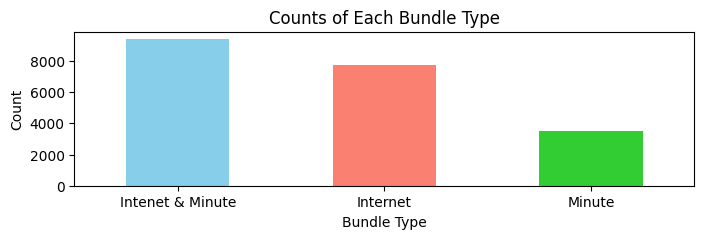

In [23]:
plt.figure(figsize=(8, 2))
df['Bundle Type'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'limegreen'])
plt.xlabel('Bundle Type')
plt.ylabel('Count')
plt.title('Counts of Each Bundle Type')
plt.xticks(rotation=0)
plt.show()


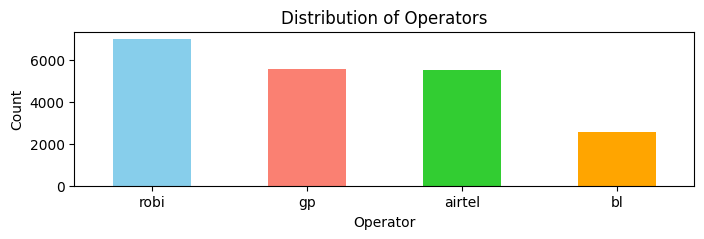

In [24]:
plt.figure(figsize=(8, 2))
df['operator'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'limegreen', 'orange'])
plt.xlabel('Operator')
plt.ylabel('Count')
plt.title('Distribution of Operators')
plt.xticks(rotation=0)
plt.show()

In [25]:
df['Product Name'].str.split()

0         [35, GB, -, 800, min]
1        [60, GB, -, 1300, min]
2                      [30, GB]
3         [35, GB, -, 800, min]
4         [35, GB, -, 800, min]
                  ...          
20630                  [20, GB]
20631                  [20, GB]
20632    [50, GB, -, 1500, min]
20633                  [20, GB]
20634                  [25, GB]
Name: Product Name, Length: 20635, dtype: object

In [26]:
df['Internet'] = df['Product Name'].str.split().str[0:2].str.join(' ')



In [27]:
df.head(1)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission,Internet
0,Intenet & Minute,gp,35 GB - 800 min,30 days,699.0,430.0,5.0,35 GB


In [28]:
df['Internet'].str.split().str[1].value_counts()

Internet
GB     17003
min     3493
MB       130
Name: count, dtype: int64

In [29]:
# df['Internet'].apply(lambda x: x.split()[0] if 'GB' in x else x)
17003 + 3493 + 130

20626

In [30]:
df['Internet'].shape

(20635,)

In [31]:
# Check unique values including any spaces or special characters
print("All unique values:")
print(df['Product Name'].str.split().str[0:2].str.join(' ').value_counts().tail(20))

# Check for null values
print("\nNull values:", df['Product Name'].isnull().sum())

# Check for empty strings or pure whitespace
print("\nEmpty strings:", df['Product Name'].str.isspace().sum())

All unique values:
Product Name
62 GB       4
55/60 GB    3
490 min     3
48 GB       3
460 min     3
1050 min    3
755 min     2
10/15 GB    2
160 min     2
14 GB       2
240 min     2
44 GB       2
250 MB      1
40/45 GB    1
66 GB       1
310 min     1
63 GB       1
11 GB       1
85 GB       1
110 GB      1
Name: count, dtype: int64

Null values: 0

Empty strings: 0


In [32]:
df['Internet'] = df['Product Name'].str.split().str[0:2].str.join(' ').apply(lambda x: 
    x.split()[0] if 'GB' in x 
    else float(x.split()[0])/1024 if 'MB' in x 
    else 0)
df.head(1)  

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission,Internet
0,Intenet & Minute,gp,35 GB - 800 min,30 days,699.0,430.0,5.0,35


In [33]:
## There are some values like '40/45' which are not possible to convert to float so we need to split and take the first value and convert to float.
# First convert to string, then handle both cases
df['Internet'] = df['Internet'].astype(str).apply(lambda x: float(x.split('/')[0] if '/' in x else x))


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20635 non-null  object 
 1   operator      20635 non-null  object 
 2   Product Name  20635 non-null  object 
 3   validity      20635 non-null  object 
 4   regularPrice  20635 non-null  float64
 5   sellingPrice  20635 non-null  float64
 6   commission    20635 non-null  float64
 7   Internet      20635 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.3+ MB


In [35]:
# df['Product Name'].str.split().str[-2:].apply(lambda x: int(x[0]) if 'min' in x else int(x))
# Create Minutes column, setting 0 for non-minute entries
df['Minutes'] = df['Product Name'].str.split().str[-2:].str.join(' ').apply(lambda x: 
    float(x.split()[0]) if 'min' in x 
    else 0)

df.head(1)



,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,Intenet & Minute,gp,35 GB - 800 min,30 days,699.0,430.0,5.0,35.0,800.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20635 non-null  object 
 1   operator      20635 non-null  object 
 2   Product Name  20635 non-null  object 
 3   validity      20635 non-null  object 
 4   regularPrice  20635 non-null  float64
 5   sellingPrice  20635 non-null  float64
 6   commission    20635 non-null  float64
 7   Internet      20635 non-null  float64
 8   Minutes       20635 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.4+ MB


In [37]:
df['validity'] = df['validity'].str.split().str[0].astype(int)

In [38]:
df.head(1)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,Intenet & Minute,gp,35 GB - 800 min,30,699.0,430.0,5.0,35.0,800.0


In [39]:
df['Bundle Type'] = df['Bundle Type'].apply(lambda x: x.replace('Intenet & Minute', 'Internet & Minute')) 

In [40]:
df['Bundle Type'].value_counts()

Bundle Type
Internet & Minute    9408
Internet             7734
Minute               3493
Name: count, dtype: int64

In [41]:
bundle_type_mapping = {'Internet & Minute': 1, 'Internet': 2, 'Minute': 3}
df['Bundle Type'] = df['Bundle Type'].map(bundle_type_mapping)
df.head(1)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,1,gp,35 GB - 800 min,30,699.0,430.0,5.0,35.0,800.0


In [42]:
operator_mapping = {'robi': 1, 'gp': 2, 'airtel': 3, 'bl': 4}
df['operator'] = df['operator'].map(operator_mapping)
df.head(1)

,Bundle Type,operator,Product Name,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,1,2,35 GB - 800 min,30,699.0,430.0,5.0,35.0,800.0


In [43]:
df['validity'] = df['validity'].astype(float)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20635 non-null  int64  
 1   operator      20635 non-null  int64  
 2   Product Name  20635 non-null  object 
 3   validity      20635 non-null  float64
 4   regularPrice  20635 non-null  float64
 5   sellingPrice  20635 non-null  float64
 6   commission    20635 non-null  float64
 7   Internet      20635 non-null  float64
 8   Minutes       20635 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.4+ MB


In [45]:
df.drop(columns=['Product Name'], inplace=True, axis=1)
df.head(1)

,Bundle Type,operator,validity,regularPrice,sellingPrice,commission,Internet,Minutes
0,1,2,30.0,699.0,430.0,5.0,35.0,800.0


In [46]:
df.describe()

,Bundle Type,operator,validity,regularPrice,sellingPrice,commission,Internet,Minutes
count,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000
mean,1.713351,2.176012,29.331476,478.980567,394.127938,24.347807,24.512176,408.586673
std,0.736925,1.034135,3.714936,238.282286,185.165177,16.099789,20.126797,435.881076
min,1.000000,1.000000,3.000000,0.000000,-507.000000,-104.000000,0.000000,0.000000
25%,1.000000,1.000000,30.000000,297.000000,255.000000,12.000000,10.000000,0.000000
50%,2.000000,2.000000,30.000000,429.000000,375.000000,25.000000,20.000000,300.000000
75%,2.000000,3.000000,30.000000,648.000000,528.000000,30.000000,40.000000,750.000000
max,3.000000,4.000000,30.000000,1498.000000,1190.000000,292.000000,120.000000,1800.000000


In [47]:
# Drop rows where regularPrice and sellingPrice is 0 and reset index
df = df[df['regularPrice'] != 0].reset_index(drop=True)
df = df[df['sellingPrice'] != 0].reset_index(drop=True)

# Make sure sellingPrice and commission contains only positive values
df['sellingPrice'] = abs(df['sellingPrice'])
df['commission'] = abs(df['commission'])
df.describe()

,Bundle Type,operator,validity,regularPrice,sellingPrice,commission,Internet,Minutes
count,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000
mean,1.713275,2.176077,29.332526,478.993166,394.211894,24.545195,24.511886,408.617554
std,0.736904,1.034152,3.711859,238.265622,185.035396,15.798668,20.125929,435.890015
min,1.000000,1.000000,3.000000,64.000000,25.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,30.000000,297.000000,255.000000,12.000000,10.000000,0.000000
50%,2.000000,2.000000,30.000000,429.000000,375.000000,25.000000,20.000000,300.000000
75%,2.000000,3.000000,30.000000,648.000000,528.000000,30.000000,40.000000,750.000000
max,3.000000,4.000000,30.000000,1498.000000,1190.000000,292.000000,120.000000,1800.000000


In [48]:
# df[df['sellingPrice'] == 25]

# Drop rows where sellingPrice is 0 and reset index
df = df[df['sellingPrice'] != 25].reset_index(drop=True)
df.describe()


,Bundle Type,operator,validity,regularPrice,sellingPrice,commission,Internet,Minutes
count,20632.000000,20632.000000,20632.000000,20632.000000,20632.000000,20632.000000,20632.000000,20632.000000
mean,1.713261,2.176086,29.332493,478.994572,394.229789,24.545173,24.511862,408.637359
std,0.736919,1.034176,3.711946,238.271311,185.022025,15.799051,20.126417,435.891295
min,1.000000,1.000000,3.000000,64.000000,40.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,30.000000,297.000000,255.000000,12.000000,10.000000,0.000000
50%,2.000000,2.000000,30.000000,429.000000,375.000000,25.000000,20.000000,300.000000
75%,2.000000,3.000000,30.000000,648.000000,528.000000,30.000000,40.000000,750.000000
max,3.000000,4.000000,30.000000,1498.000000,1190.000000,292.000000,120.000000,1800.000000


In [49]:
df.info()
# df.to_csv("../data/processed/data.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20632 entries, 0 to 20631
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bundle Type   20632 non-null  int64  
 1   operator      20632 non-null  int64  
 2   validity      20632 non-null  float64
 3   regularPrice  20632 non-null  float64
 4   sellingPrice  20632 non-null  float64
 5   commission    20632 non-null  float64
 6   Internet      20632 non-null  float64
 7   Minutes       20632 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.3 MB


# Split the data into training and testing

In [50]:

from sklearn.model_selection import train_test_split

# Split the data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# save the data
train_df.to_csv("../data/processed/train_data.csv", index=False)
test_df.to_csv("../data/processed/test_data.csv", index=False)

In [52]:
# Check the shape of the data
test_df.shape, train_df.shape


((4127, 8), (16505, 8))

In [54]:
df.columns

Index(['Bundle Type', 'operator', 'validity', 'regularPrice', 'sellingPrice',
       'commission', 'Internet', 'Minutes'],
      dtype='object')

In [55]:
# Now train the random forest model for the training data and predict the test data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features for training
features = ['Bundle Type', 'operator', 'validity', 'regularPrice', 'sellingPrice', 'Internet', 'Minutes']
target = 'commission'

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(train_df[features], train_df[target])

# Make predictions on test data
test_predictions = rf_model.predict(test_df[features])

# Calculate metrics
mse = mean_squared_error(test_df[target], test_predictions)
r2 = r2_score(test_df[target], test_predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))


Mean Squared Error: 98.85
R2 Score: 0.61

Feature Importance:
        feature  importance
3  regularPrice    0.393927
4  sellingPrice    0.263158
6       Minutes    0.192174
5      Internet    0.088979
1      operator    0.038103
2      validity    0.016977
0   Bundle Type    0.006682


In [56]:
# save the model
import joblib
# joblib.dump(rf_model, '../models/rf_model.pkl')


['../models/rf_model.pkl']